<a href="https://colab.research.google.com/github/ProfessorAbraham/10academy-week1-sentiment-stock-analysis/blob/main/notebooks/task_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%cd /content
!rm -rf 10academy-week1-sentiment-stock-analysis
!git clone https://github.com/ProfessorAbraham/10academy-week1-sentiment-stock-analysis.git

/content
Cloning into '10academy-week1-sentiment-stock-analysis'...
remote: Enumerating objects: 43, done.
remote: Counting objects: 100% (43/43), done.
remote: Compressing objects: 100% (34/34), done.
remote: Total 43 (delta 16), reused 14 (delta 2), pack-reused 0 (from 0)
Receiving objects: 100% (43/43), 1.92 MiB | 4.76 MiB/s, done.
Resolving deltas: 100% (16/16), done.


In [ ]:
%cd /content/10academy-week1-sentiment-stock-analysis

/content/10academy-week1-sentiment-stock-analysis


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [17]:
import pandas as pd
from textblob import TextBlob
import numpy as np
import matplotlib.pyplot as plt


In [24]:
!pip install -q textblob


In [25]:
news_path = '/content/drive/MyDrive/raw_analyst_ratings.csv'
stock_data_folder = '/content/drive/MyDrive/yfinance_data'

# Load sentiment data
news_df = pd.read_csv(news_path)

In [26]:
from textblob import TextBlob

# Function to get sentiment polarity
def get_sentiment(text):
    if pd.isna(text):
        return None
    return TextBlob(text).sentiment.polarity  # Range: [-1, 1]

# Apply sentiment scoring to each headline
news_df['sentiment'] = news_df['headline'].apply(get_sentiment)

# Drop rows with missing sentiment, date, or stock
news_df = news_df.dropna(subset=['sentiment', 'date', 'stock'])

# Confirm
print(news_df[['headline', 'sentiment']].head())

                                            headline  sentiment
0            Stocks That Hit 52-Week Highs On Friday        0.0
1         Stocks That Hit 52-Week Highs On Wednesday        0.0
2                      71 Biggest Movers From Friday        0.0
3       46 Stocks Moving In Friday's Mid-Day Session        0.0
4  B of A Securities Maintains Neutral on Agilent...        0.0


In [29]:
# Ensure date is datetime
news_df['date'] = pd.to_datetime(news_df['date'], format='mixed', errors='coerce')
news_df.dropna(subset=['date'], inplace=True)

# Group by date and stock to get average sentiment per day
daily_sentiment = news_df.groupby(['date', 'stock'])['sentiment'].mean().reset_index()

# Preview
daily_sentiment.head()

,date,stock,sentiment
0,2020-05-22 08:06:17-04:00,A,0.00
1,2020-05-22 08:06:17-04:00,CVTI,0.00
2,2020-05-22 08:37:59-04:00,A,0.00
3,2020-05-22 09:07:04-04:00,A,0.25
4,2020-05-22 09:36:20-04:00,A,0.00


Stock data sample:
         date stock  daily_return
1  1980-12-15  AAPL     -0.052171
2  1980-12-16  AAPL     -0.073398
3  1980-12-17  AAPL      0.024751
4  1980-12-18  AAPL      0.028992
5  1980-12-19  AAPL      0.061029
News data columns: Index(['Unnamed: 0', 'headline', 'url', 'publisher', 'date', 'stock'], dtype='object')
Daily sentiment sample:
         date stock  sentiment
0  2011-04-27   DGP   0.000000
1  2011-04-28   DEJ   0.000000
2  2011-04-28   ESR   0.136364
3  2011-04-29   AIA  -0.166667
4  2011-04-29   GDL   0.500000
Merged data sample:
         date stock  sentiment  daily_return
0  2020-06-02  NVDA   0.250000      0.002158
1  2020-06-04  GOOG   0.000000     -0.016848
2  2020-06-05  GOOG  -0.051852      0.018560
3  2020-06-08  GOOG   0.139394      0.005715
4  2020-06-08  NVDA   0.000000     -0.012892
Pearson correlation coefficient between sentiment and daily return: -0.0033
P-value: 9.9114e-01


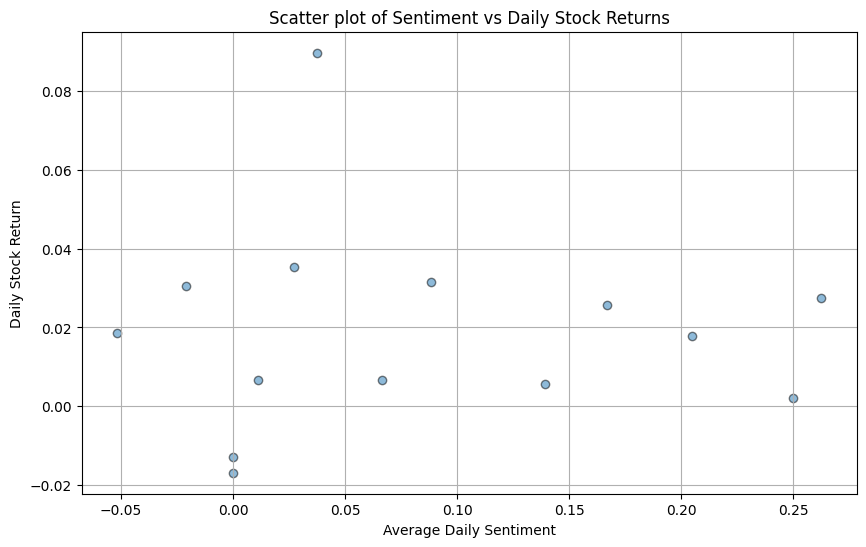

In [36]:
import os
import pandas as pd
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
# Uncomment if you need to do sentiment analysis from headlines
from textblob import TextBlob

# --- Step 1: Load and prepare all stock CSV files from yfinance_data folder ---

stock_folder = '/content/drive/MyDrive/yfinance_data'  # Update to your stock data folder path
stock_dfs = []

for file in os.listdir(stock_folder):
    if file.endswith('.csv'):
        stock_name = file.split('.')[0].upper()  # Stock ticker, uppercase
        df = pd.read_csv(os.path.join(stock_folder, file))
        df['date'] = pd.to_datetime(df['Date'], errors='coerce')
        df['stock'] = stock_name
        df['daily_return'] = df['Close'].pct_change()
        stock_dfs.append(df[['date', 'stock', 'daily_return']])

# Combine all stocks into one DataFrame
stock_df = pd.concat(stock_dfs, ignore_index=True)

# Drop rows where daily_return is NA (first row of each stock)
stock_df.dropna(subset=['daily_return'], inplace=True)

# --- Normalize stock tickers in stock data ---

# Remove suffixes like '_HISTORICAL_DATA' if present to match news tickers
stock_df['stock'] = stock_df['stock'].str.replace('_HISTORICAL_DATA', '', regex=False)

# Convert dates to date only (no time)
stock_df['date'] = stock_df['date'].dt.date

print("Stock data sample:")
print(stock_df.head())

# --- Step 2: Load and prepare news sentiment data ---

news_path = '/content/drive/MyDrive/raw_analyst_ratings.csv'  # Update to your news data CSV path
news_df = pd.read_csv(news_path)

print("News data columns:", news_df.columns)

# Convert 'date' to datetime, then date only (remove time)
news_df['date'] = pd.to_datetime(news_df['date'], errors='coerce').dt.date

# Drop rows with missing 'date', 'stock', or 'headline'
news_df = news_df.dropna(subset=['date', 'stock', 'headline'])

# --- Optional: Compute sentiment if missing ---

if 'sentiment' not in news_df.columns:
    # Install TextBlob if necessary (uncomment if running for first time)
    # !pip install -q textblob
    from textblob import TextBlob
    news_df['sentiment'] = news_df['headline'].apply(lambda x: TextBlob(x).sentiment.polarity)

# Uppercase stock tickers for safe merging
news_df['stock'] = news_df['stock'].str.upper()

# --- Step 3: Aggregate sentiment by date and stock ---

daily_sentiment = news_df.groupby(['date', 'stock'])['sentiment'].mean().reset_index()

print("Daily sentiment sample:")
print(daily_sentiment.head())

# --- Step 4: Merge stock returns with daily sentiment ---

merged_df = pd.merge(daily_sentiment, stock_df, on=['date', 'stock'], how='inner')

# Drop rows with NA in key columns
merged_df = merged_df.dropna(subset=['sentiment', 'daily_return'])

print("Merged data sample:")
print(merged_df.head())

# Check if merged_df is empty to avoid errors later
if merged_df.empty:
    raise ValueError("Merged dataframe is empty — check if dates and stock tickers match between news and stock data.")

# --- Step 5: Correlation analysis ---

corr_coef, p_value = pearsonr(merged_df['sentiment'], merged_df['daily_return'])

print(f"Pearson correlation coefficient between sentiment and daily return: {corr_coef:.4f}")
print(f"P-value: {p_value:.4e}")

# --- Step 6: Visualization ---

plt.figure(figsize=(10,6))
plt.scatter(merged_df['sentiment'], merged_df['daily_return'], alpha=0.5, edgecolors='k')
plt.title('Scatter plot of Sentiment vs Daily Stock Returns')
plt.xlabel('Average Daily Sentiment')
plt.ylabel('Daily Stock Return')
plt.grid(True)
plt.show()


In [32]:
# Ensure datetime columns are timezone-naive
daily_sentiment['date'] = pd.to_datetime(daily_sentiment['date']).dt.tz_localize(None)
stock_df['date'] = pd.to_datetime(stock_df['date']).dt.tz_localize(None)

# Merge sentiment and stock returns on date and stock
merged_df = pd.merge(daily_sentiment, stock_df, on=['date', 'stock'])

# Drop rows with missing values
merged_df.dropna(subset=['sentiment', 'daily_return'], inplace=True)

# Preview the merged DataFrame
merged_df.head()


,date,stock,sentiment,daily_return
